# AML Project: Soccer Odds Prediction

This Notebook predicts football results (Win Home-Team / Draw / Win Away-Team) by using historical football data. Based on the Prediction Probabilities, we calculate betting odds.

Data Source: https://www.kaggle.com/competitions/football-match-probability-prediction/data?select=train.csv

Some Ideas are based on this Notebook: https://www.kaggle.com/code/adewoleakorede/football-match-probability-prediction

Team Members:
- Pascal Schmidt
- Philipp Becht
- Simon Wrigg

WWI19DSB @DHBW Mannheim

## Setup

In [ ]:
# module imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import pickle

In [ ]:
# load kaggle data from public google drive
!gdown --id 1vSUuSvfeKhEdyvW3K117t-nkc3DONkrE
!unzip /content/football-match-probability-prediction.zip -d /content/
%rm -rf /content/*.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1vSUuSvfeKhEdyvW3K117t-nkc3DONkrE
To: /content/football-match-probability-prediction.zip
100% 68.0M/68.0M [00:00<00:00, 105MB/s]
Archive:  /content/football-match-probability-prediction.zip
  inflating: /content/sample_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      
  inflating: /content/train_target_and_scores.csv  


In [ ]:
# create dataframe for train data
football_data = pd.read_csv("/content/train.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# train-test-split (since the given test data has no target to check accuracy)
# take 85000 matches as train data
train_data = football_data[:85000]
test_data = football_data[85000:]

In [ ]:
# create dataframe for scores data
scores_data = pd.read_csv("/content/train_target_and_scores.csv")

## Data Exploration

### General Infos

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Columns: 190 entries, id to away_team_history_league_id_10
dtypes: float64(162), int64(2), object(26)
memory usage: 123.2+ MB


In [58]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25938 entries, 85000 to 110937
Columns: 185 entries, id to league_name_encoded
dtypes: float64(176), int64(5), object(4)
memory usage: 36.6+ MB


In [ ]:
train_data.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
0,11906497,away,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,False,468196.0,468200.0,...,1122.0,642.0,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0
1,11984383,home,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,False,516788.0,22169161.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0
2,11983301,draw,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,False,2510608.0,456313.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0
3,11983471,away,León,Morelia,2019-12-01 01:00:00,Liga MX,743,False,1552508.0,465797.0,...,743.0,743.0,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0
4,11883005,home,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,False,429958.0,426870.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0


### Most common Scores

In [ ]:
# Display most common results
score_df = scores_data.groupby("score").count()
score_df = score_df[score_df["id"]>5000]
score_df = score_df.sort_values("id", ascending=False)
score_df = score_df.rename(columns = {"id": "matches"})
score_df = score_df.drop("target", 1)
score_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,matches
score,
1-1,12583
1-0,11126
0-1,8952
2-1,8912
0-0,8829
2-0,7582
1-2,7366
0-2,5296
2-2,5044


### Target Variable Analysis

In [ ]:
# display distribution of the target variable in percentages
# As we can see, home team win probability is ~ 43,6%
train_data["target"].value_counts(normalize=True)*100

home    43.575294
away    31.836471
draw    24.588235
Name: target, dtype: float64

[Text(0, 0.5, 'Matches'),
 Text(0.5, 0, 'Target'),
 Text(0.5, 1.0, 'Target Variable Distribution')]

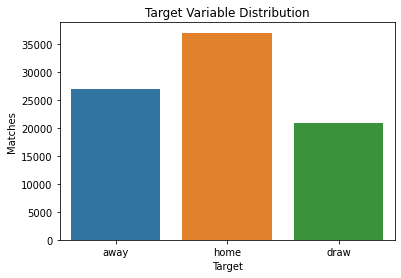

In [ ]:
# plot distribution of target variable
sns.countplot(x='target', data=train_data).set(xlabel='Target', ylabel='Matches', title='Target Variable Distribution')

In [ ]:
# display distribution of the target variable for the cup games
# As we can see, there are less draws in cups than in normal league games
# Conclusion: Is_cup is relevant information for the target prediction
cup_data = train_data[train_data["is_cup"] == 1]
cup_data["target"].value_counts(normalize=True)*100

home    42.839387
away    35.906643
draw    21.253970
Name: target, dtype: float64

### League Analysis

In [ ]:
# display distribution of the leagues
train_data["league_name"].value_counts().head(10)

Premier League      4215
Club Friendlies     3478
Primera Division    1839
Super League        1191
3. Liga              916
Ligue 1              879
Serie B              835
Championship         822
Serie A              816
League One           750
Name: league_name, dtype: int64

In [ ]:
# display some Bundesliga matches
(test_data[test_data["league_name"] == "Bundesliga"]).tail(10)

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
107986,16840338,away,Stuttgart,Wolfsburg,2021-04-21 18:30:00,Bundesliga,82,False,45305.0,51518.0,...,82.0,82.0,82.0,82.0,82.0,82.0,109.0,82.0,82.0,82.0
107987,16840336,away,Werder Bremen,Mainz 05,2021-04-21 18:30:00,Bundesliga,82,False,460266.0,29535.0,...,82.0,82.0,1101.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0
108404,16840347,away,Augsburg,Köln,2021-04-23 18:30:00,Bundesliga,82,False,460085.0,456663.0,...,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0
108792,16840344,home,Union Berlin,Werder Bremen,2021-04-24 13:30:00,Bundesliga,82,False,455712.0,460266.0,...,82.0,82.0,82.0,109.0,82.0,82.0,82.0,82.0,82.0,82.0
108793,16840343,draw,Freiburg,Hoffenheim,2021-04-24 13:30:00,Bundesliga,82,False,460197.0,38217.0,...,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,5.0,82.0
108794,16840342,away,Wolfsburg,Borussia Dortmund,2021-04-24 13:30:00,Bundesliga,82,False,51518.0,417317.0,...,82.0,82.0,2.0,82.0,2.0,82.0,82.0,82.0,2.0,82.0
108796,16840346,home,Mainz 05,Bayern München,2021-04-24 13:30:00,Bundesliga,82,False,29535.0,37352367.0,...,82.0,82.0,2.0,82.0,2.0,82.0,82.0,2.0,82.0,82.0
109056,16840341,home,Bayer Leverkusen,Eintracht Frankfurt,2021-04-24 16:30:00,Bundesliga,82,False,459565.0,455978.0,...,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0
109555,16840339,home,RB Leipzig,Stuttgart,2021-04-25 13:30:00,Bundesliga,82,False,458813.0,45305.0,...,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0
109708,16840340,home,Borussia M'gladbach,Arminia Bielefeld,2021-04-25 16:00:00,Bundesliga,82,False,29710.0,37336957.0,...,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0


In [ ]:
# Example comparison: Target distribution per league
# In this example: Primera Divison has more draws and home team wins, Premier League has 5% more away wins
# Conclusion: Target dependency on league is given
print("Premier League:\n", train_data[train_data["league_name"] == "Premier League"]["target"].value_counts(normalize=True)*100)
print("\n")
print("Primera Division:\n", train_data[train_data["league_name"] == "Primera Division"]["target"].value_counts(normalize=True)*100)

Premier League:
 home    40.427046
away    33.072361
draw    26.500593
Name: target, dtype: float64


Primera Division:
 home    42.468733
draw    29.581294
away    27.949973
Name: target, dtype: float64


### Data Distribution Check

In [ ]:
train_data.describe()

,id,league_id,home_team_coach_id,away_team_coach_id,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
count,8.500000e+04,85000.000000,6.922600e+04,6.915500e+04,83960.000000,82828.000000,81673.000000,80545.000000,79396.000000,78217.000000,...,83905.000000,82709.000000,81468.000000,80220.000000,78997.000000,77815.000000,76651.000000,75465.000000,74263.000000,73083.000000
mean,1.454505e+07,894.994153,1.286706e+07,1.290437e+07,0.308361,0.564700,0.468282,0.517301,0.488173,0.506552,...,883.447864,873.902949,864.995336,855.969048,847.290176,839.888813,831.689880,822.719897,816.608136,808.104457
std,2.520848e+06,547.361673,1.577093e+07,1.577469e+07,0.461819,0.495799,0.498996,0.499704,0.499863,0.499960,...,543.181897,539.120131,535.005892,530.969684,527.080924,523.325112,520.380926,516.835534,513.799999,510.955168
min,1.142829e+07,2.000000,2.000000e+00,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,1.198412e+07,426.000000,4.596750e+05,4.596470e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,420.000000,408.000000,399.000000,390.000000,387.000000,387.000000,384.000000,378.000000,375.000000,372.000000
50%,1.480885e+07,926.000000,1.552705e+06,1.552806e+06,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,899.000000,884.000000,881.000000,860.000000,848.000000,830.000000,812.000000,803.000000,791.000000,776.000000
75%,1.705429e+07,1283.000000,3.243116e+07,3.255135e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1281.000000,1275.000000,1271.000000,1268.000000,1265.000000,1262.000000,1260.000000,1255.000000,1253.000000,1252.000000
max,1.789343e+07,2028.000000,3.755472e+07,3.755471e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2026.000000,2017.000000,2017.000000,2014.000000,2014.000000,1987.000000,1992.000000,1992.000000,1987.000000,1983.000000


## Data Preperation / Feature Engineering

### Target Encoding

2 = win home; 1 = draw; 0 = win away

In [ ]:
# Encode Target Class
# 2=home, 1=draw, 0=away (good to check correlations)
encoder = LabelEncoder()
encoder.fit(train_data['target'])

train_data['target'] = encoder.transform(train_data['target'])

# show encoded targets
train_data['target'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2    37039
0    27061
1    20900
Name: target, dtype: int64

In [ ]:
# target encoding in test data
encoder.fit(test_data['target'])
test_data['target'] = encoder.transform(test_data['target'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Feature Creation




#### Goals and Ratings last 10 matches
New Features: Average of last 10 matches, respectively for home & away team:
1. Rating (Team Rating by Octosport)
2. Oponnent Rating
2. Scored goals 
2. Conceded goals 

In [ ]:
def features_goals_ratings_last_10(df):
  
  # create feature name lists for the 1-10 last games
  # history rating
  homerating_features = []
  awayrating_features = []
  homeopponent_rating_features = []
  awayopponent_rating_features = []
  # history goals
  homegoal_features = []
  awaygoal_features = []
  homeoponnent_goal_features = []
  awayopponent_goal_features = []

  # fill feature name lists with column names (1-10 last games)
  for i in range(1,11):
    # rating features
    homerating_features.append(f"home_team_history_rating_{i}")
    awayrating_features.append(f"away_team_history_rating_{i}")
    homeopponent_rating_features.append(f"home_team_history_opponent_rating_{i}")
    awayopponent_rating_features.append(f"away_team_history_opponent_rating_{i}")
    # goal features
    homegoal_features.append(f"home_team_history_goal_{i}")
    awaygoal_features.append(f"away_team_history_goal_{i}")
    homeoponnent_goal_features.append(f"home_team_history_opponent_goal_{i}")
    awayopponent_goal_features.append(f"away_team_history_opponent_goal_{i}")

  # create new aggregated features (aggregate to get the mean values)
  # rating features
  df["avg_home_rating_last_10"] = df[homerating_features].mean(axis=1)
  df["avg_away_rating_last_10"] = df[awayrating_features].mean(axis=1)
  df["avg_home_opponent_rating_last_10"] = df[homeopponent_rating_features].mean(axis=1)
  df["avg_away_opponent_rating_last_10"] = df[awayopponent_rating_features].mean(axis=1)

  # goal features
  df["avg_home_goals_last_10"] = df[homegoal_features].mean(axis=1)
  df["avg_away_goals_last_10"] = df[awaygoal_features].mean(axis=1)
  df["avg_home_opponent_goals_last_10"] = df[homeoponnent_goal_features].mean(axis=1)
  df["avg_away_opponent_goals_last_10"] = df[awayopponent_goal_features].mean(axis=1)

In [ ]:
# execute the functions to create the features
features_goals_ratings_last_10(train_data)
features_goals_ratings_last_10(test_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

#### Match Results last 5 matches


1. Calculate the goal difference in the last matches

2. Based on the goal differences, decide if the team won/draw/lost the match

3. Create features for number of wins/draws/losses in the last 5 games (=recent performance)

In [ ]:
def features_results_last_5(df):

  for i in range(1, 6):
    # goal differences in last 5 matches
    df[f"home_goal_diff_{i}"] = df[f'home_team_history_goal_{i}'] - df[f'home_team_history_opponent_goal_{i}']
    df[f"away_goal_diff_{i}"] = df[f'away_team_history_goal_{i}'] - df[f'away_team_history_opponent_goal_{i}']

    # winner/draw/loser in last 5 matches (derived from goal differences)
    df[f'home_winner_{i}'] = np.where(df[f"home_goal_diff_{i}"] > 0, 1., 0.)
    df[f'away_winner_{i}'] = np.where(df[f"away_goal_diff_{i}"] > 0, 1., 0.)
    df[f'home_draw_{i}'] = np.where(df[f"home_goal_diff_{i}"] == 0, 1., 0.)
    df[f'away_draw_{i}'] = np.where(df[f"away_goal_diff_{i}"] == 0, 1., 0.)
    df[f'home_loser_{i}'] = np.where(df[f"home_goal_diff_{i}"] < 0, 1., 0.)
    df[f'away_loser_{i}'] = np.where(df[f"away_goal_diff_{i}"] < 0, 1., 0.)

  # number of wins/draws/loses in last 5 matches
  home_winner_features = []
  away_winner_features = []
  home_draw_features = []
  away_draw_features = []
  home_loser_features = []
  away_loser_features = []

  for i in range(1, 6):
    home_winner_features.append(f'home_winner_{i}')
    away_winner_features.append(f'away_winner_{i}')
    home_draw_features.append(f'home_draw_{i}')
    away_draw_features.append(f'away_draw_{i}')
    home_loser_features.append(f'home_loser_{i}')
    away_loser_features.append(f'away_loser_{i}')

  # create new columns (features)
  df["home_wins_last_5"] = df[home_winner_features].sum(axis=1)
  df["away_wins_last_5"] = df[away_winner_features].sum(axis=1)
  df["home_draws_last_5"] = df[home_draw_features].sum(axis=1)
  df["away_draws_last_5"] = df[away_draw_features].sum(axis=1)
  df["home_losses_last_5"] = df[home_loser_features].sum(axis=1)
  df["away_losses_last_5"] = df[away_loser_features].sum(axis=1)

In [ ]:
# execute the functions to create the features
features_results_last_5(train_data)
features_results_last_5(test_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
train_data.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,home_draw_5,away_draw_5,home_loser_5,away_loser_5,home_wins_last_5,away_wins_last_5,home_draws_last_5,away_draws_last_5,home_losses_last_5,away_losses_last_5
0,11906497,0,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,False,468196.0,468200.0,...,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,3.0,2.0
1,11984383,2,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,False,516788.0,22169161.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,4.0,3.0
2,11983301,1,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,False,2510608.0,456313.0,...,0.0,0.0,1.0,0.0,3.0,3.0,0.0,1.0,2.0,1.0
3,11983471,0,León,Morelia,2019-12-01 01:00:00,Liga MX,743,False,1552508.0,465797.0,...,0.0,0.0,1.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0
4,11883005,2,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,False,429958.0,426870.0,...,1.0,1.0,0.0,0.0,3.0,2.0,1.0,2.0,1.0,1.0


In [ ]:
# check correlations of features to target
corr = train_data.corr()["target"]
print(corr.sort_values(ascending=False).head(10))

target                                 1.000000
home_wins_last_5                       0.142475
avg_home_rating_last_10                0.135081
avg_away_opponent_rating_last_10       0.130792
avg_away_opponent_goals_last_10        0.129624
avg_home_goals_last_10                 0.129322
away_losses_last_5                     0.117781
home_team_history_rating_2             0.106164
home_team_history_rating_1             0.102804
away_team_history_opponent_rating_1    0.100901
Name: target, dtype: float64


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Columns: 244 entries, id to away_losses_last_5
dtypes: float64(216), int64(3), object(25)
memory usage: 158.2+ MB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25938 entries, 85000 to 110937
Columns: 244 entries, id to away_losses_last_5
dtypes: float64(216), int64(3), object(25)
memory usage: 48.3+ MB


### Deletion of unnecessary columns

Columns to delete:
- Date columns
- League IDs
- Coach IDs

In [ ]:
def delete_columns(df):

  # column lists to drop
  history_home_date_features = []
  history_away_date_features = []
  history_home_league_features = []
  history_away_league_features = []
  history_home_coach_features = []
  history_away_coach_features = []

  # fill column drop lists
  for i in range(1,11):
    history_home_date_features.append(f"home_team_history_match_date_{i}")
    history_away_date_features.append(f"away_team_history_match_date_{i}")
    history_home_league_features.append(f"home_team_history_league_id_{i}")
    history_away_league_features.append(f"away_team_history_league_id_{i}")
    history_home_coach_features.append(f"home_team_history_coach_{i}")
    history_away_coach_features.append(f"away_team_history_coach_{i}")

  # delete columns by using the created lists
  df = df.drop(columns = history_home_date_features)
  df = df.drop(columns = history_away_date_features)
  df = df.drop(columns = history_home_league_features)
  df = df.drop(columns = history_away_league_features)
  df = df.drop(columns = history_home_coach_features)
  df = df.drop(columns = history_away_coach_features)

  return df

In [ ]:
# execute the function to delete columns
train_data = delete_columns(train_data)
test_data = delete_columns(test_data)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Columns: 184 entries, id to away_losses_last_5
dtypes: float64(176), int64(3), object(5)
memory usage: 119.3+ MB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25938 entries, 85000 to 110937
Columns: 184 entries, id to away_losses_last_5
dtypes: float64(176), int64(3), object(5)
memory usage: 36.4+ MB


In [ ]:
train_data.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,home_draw_5,away_draw_5,home_loser_5,away_loser_5,home_wins_last_5,away_wins_last_5,home_draws_last_5,away_draws_last_5,home_losses_last_5,away_losses_last_5
0,11906497,0,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,False,468196.0,468200.0,...,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,3.0,2.0
1,11984383,2,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,False,516788.0,22169161.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,4.0,3.0
2,11983301,1,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,False,2510608.0,456313.0,...,0.0,0.0,1.0,0.0,3.0,3.0,0.0,1.0,2.0,1.0
3,11983471,0,León,Morelia,2019-12-01 01:00:00,Liga MX,743,False,1552508.0,465797.0,...,0.0,0.0,1.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0
4,11883005,2,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,False,429958.0,426870.0,...,1.0,1.0,0.0,0.0,3.0,2.0,1.0,2.0,1.0,1.0


### Additional Preperation

In [ ]:
# encode non-numeric data which is important for the model training
# is_cup
# in train data
encoder.fit(train_data['is_cup'])
train_data['is_cup'] = encoder.transform(train_data['is_cup'])
# also in test data
test_data['is_cup'] = encoder.fit_transform(test_data['is_cup'])

In [ ]:
# encode league_name (as it differs from league_id)
# in train data
encoder.fit(train_data['league_name'])
train_data['league_name_encoded'] = encoder.transform(train_data['league_name'])
# also in test data
test_data['league_name_encoded'] = encoder.fit_transform(test_data['league_name'])

In [ ]:
train_data.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_draw_5,home_loser_5,away_loser_5,home_wins_last_5,away_wins_last_5,home_draws_last_5,away_draws_last_5,home_losses_last_5,away_losses_last_5,league_name_encoded
0,11906497,0,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,0,468196.0,468200.0,...,0.0,0.0,0.0,2.0,3.0,0.0,0.0,3.0,2.0,605
1,11984383,2,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,0,516788.0,22169161.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,4.0,3.0,500
2,11983301,1,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,0,2510608.0,456313.0,...,0.0,1.0,0.0,3.0,3.0,0.0,1.0,2.0,1.0,361
3,11983471,0,León,Morelia,2019-12-01 01:00:00,Liga MX,743,0,1552508.0,465797.0,...,0.0,1.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,358
4,11883005,2,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,0,429958.0,426870.0,...,1.0,0.0,0.0,3.0,2.0,1.0,2.0,1.0,1.0,361


In [ ]:
# print all columns to check
for col in train_data.columns:
    print(col)

## Model Training, Evaluation and Odds Calculation

### Pipeline Transformation

In [ ]:
# export test dataframe to csv
# this dataframe is used by the FastAPI (data for prediction)
test_data.to_csv(r"test_soccer_data.csv")

In [ ]:
# Preperations

target = train_data['target']
y_target = test_data['target']
y_train = np.array(target)
y_test = np.array(y_target)

X_train = train_data.drop(columns=['id', 'target', 'home_team_name', 'away_team_name', 'league_name', 'match_date', 'home_team_coach_id', 'away_team_coach_id'])
X_test = test_data.drop(columns=['id', 'target', 'home_team_name', 'away_team_name', 'league_name', 'match_date', 'home_team_coach_id', 'away_team_coach_id'])
X_train.shape, X_test.shape

((85000, 177), (25938, 177))

In [ ]:
# create Pipeline
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

pipeline.fit(X_train)
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

### Models + Evaluation

#### Baseline Model

The Baseline would be to predict that home team wins in every match. (Home Team with highest Apriori)

--> We would get an acurracy of 42,7% on the test data

In [ ]:
test_data["target"].value_counts(normalize=True)*100

2    42.694117
0    31.278433
1    26.027450
Name: target, dtype: float64

#### Logistic Regression

##### training and evaluation

In [ ]:
# Training of Logistic Regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(multi_class='multinomial')

In [ ]:
# make predictions
y_pred = model.predict(X_test)
y_pred[:5]

array([2, 2, 2, 0, 0])

In [ ]:
y_test[:5]

array([2, 2, 2, 0, 2])

In [ ]:
# calculate acurracy
print(accuracy_score(y_test, y_pred))

0.4954506901071787


In [ ]:
# show the predictiion probabilities
predict_proba = model.predict_proba(X_test)
predict_proba[:5]

array([[0.22172038, 0.27152929, 0.50675033],
       [0.2824887 , 0.27758871, 0.43992259],
       [0.27606619, 0.20053513, 0.52339868],
       [0.46606673, 0.2755534 , 0.25837987],
       [0.46478571, 0.29466327, 0.24055102]])

In [ ]:
match_info_df = test_data[["id", "home_team_name", "away_team_name", "league_name"]].reset_index()

In [ ]:
# create one result dataframe with probablities, predictions and real results
predict_proba_df = pd.DataFrame(predict_proba, columns = ['away', 'draw', "home"])
predict_df = pd.DataFrame(y_pred, columns = ['prediction'])
real_test_df = pd.DataFrame(y_test, columns = ['real_result'])
# concatenate the dataframes
test_result_df = pd.concat([match_info_df, predict_proba_df, predict_df, real_test_df], axis=1)

In [ ]:
test_result_df.head(8)

,index,id,home_team_name,away_team_name,league_name,away,draw,home,prediction,real_result
0,85000,16839705,Karviná,Opava,Fortuna Liga,0.221720,0.271529,0.506750,2,2
1,85001,16839708,Bohemians 1905,Zbrojovka Brno,Fortuna Liga,0.282489,0.277589,0.439923,2,2
2,85002,17758426,Darlington,Wealdstone,Fa Trophy,0.276066,0.200535,0.523399,2,2
3,85003,17267976,Badajoz U19,Atl. Madrid U19,Spain Youth League,0.466067,0.275553,0.258380,0,0
4,85004,17152317,Weymouth,Bromley,National League,0.464786,0.294663,0.240551,0,2
5,85005,17757214,AFC Hornchurch,Maidstone United,Fa Trophy,0.305368,0.229693,0.464940,2,2
6,85006,17757213,Oxford City,Peterborough Sports,Fa Trophy,0.326384,0.221634,0.451982,2,2
7,85007,17671510,Enyimba,Plateau United,Npfl,0.270008,0.313878,0.416115,2,2


##### advanced evaluation

In [ ]:
# just keep matches where predicted outcome probability >= 50%
test_result_over_50_df = test_result_df.loc[(test_result_df['away'] >= 0.5) | (test_result_df['draw'] >= 0.5) | (test_result_df['home'] >= 0.5)] 

In [ ]:
test_result_over_50_df.head()

,index,id,home_team_name,away_team_name,league_name,away,draw,home,prediction,real_result
0,85000,16839705,Karviná,Opava,Fortuna Liga,0.221720,0.271529,0.506750,2,2
2,85002,17758426,Darlington,Wealdstone,Fa Trophy,0.276066,0.200535,0.523399,2,2
11,85011,17244889,Colegios Diocesanos,Cultural Cebrereña,Tercera - Group 8,0.245586,0.247556,0.506857,2,2
12,85012,17759134,Al Qadsia,Al Salmiyah,Premier League,0.240312,0.203061,0.556626,2,2
14,85014,17267978,Rayo Majadahonda U19,Los Yébenes SB U19,Spain Youth League,0.235596,0.170049,0.594356,2,2


In [ ]:
# 10000 / 25000 remain when keeping the <50% matches
test_result_over_50_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9912 entries, 0 to 25934
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           9912 non-null   int64  
 1   id              9912 non-null   int64  
 2   home_team_name  9912 non-null   object 
 3   away_team_name  9912 non-null   object 
 4   league_name     9912 non-null   object 
 5   away            9912 non-null   float64
 6   draw            9912 non-null   float64
 7   home            9912 non-null   float64
 8   prediction      9912 non-null   int64  
 9   real_result     9912 non-null   int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 851.8+ KB


In [ ]:
real_result_50_array = test_result_over_50_df["real_result"].to_numpy()
prediction_50_array = test_result_over_50_df["prediction"].to_numpy()

In [ ]:
# The acuraccy gets 10% better when we just take games with probabilities more than 50%
print(accuracy_score(real_result_50_array, prediction_50_array))

0.6132970137207425


#### XGBoost

We choose the eXtreme Gradient Boosting Model as productive Model in our project as it fits best to the use case and has a high accuracy.

In [ ]:
# train xgboost model
xgb = GradientBoostingClassifier()
xgb.fit(X_train, y_train)

GradientBoostingClassifier()

In [60]:
# make predictions
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb[:25]

array([2, 2, 2, 0, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 0])

In [ ]:
# calculate acurracy
print(accuracy_score(y_test, y_pred_xgb))

0.494833834528491


In [ ]:
# show most important features (feature importance)
features = test_data.drop(columns=['id', 'target', 'home_team_name', 'away_team_name', 'league_name', 'match_date', 'home_team_coach_id', 'away_team_coach_id'])
feature_importances=pd.DataFrame({'features':features.columns,'feature_importance':xgb.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False).head(20)

,features,feature_importance
124,avg_home_opponent_rating_last_10,0.155693
123,avg_away_rating_last_10,0.132878
122,avg_home_rating_last_10,0.122637
125,avg_away_opponent_rating_last_10,0.117002
129,avg_away_opponent_goals_last_10,0.050209
128,avg_home_opponent_goals_last_10,0.042318
170,home_wins_last_5,0.040748
171,away_wins_last_5,0.027714
127,avg_away_goals_last_10,0.027415
126,avg_home_goals_last_10,0.018449


In [65]:
# hyperparameter tuning

# select reasonable parameters to execute a grid search
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000]}

gridsearch = GridSearchCV(estimator=xgb, param_grid=params, scoring='accuracy', verbose=1)

# fit on the data
gridsearch.fit(X_train, y_train)

# print best parameter settings
print("Best parameters:", gridsearch.best_params_)

#### Random Forest Classifier

RFR has a worse acurracy

In [ ]:
# train RFC model
rfc = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1, max_depth=4, max_features=6)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=6, n_estimators=1000,
                       n_jobs=-1, random_state=42)

In [ ]:
y_pred_rfc = rfc.predict(X_test)
y_pred_rfc[:10]

array([2, 2, 2, 0, 2, 2, 2, 2, 0, 2])

In [ ]:
# calculate acurracy
print(accuracy_score(y_test, y_pred_rfc))
# model performs worse than base model --> do not use random forest

0.46965841622330173


### Prediction results with odds

In [ ]:
def predict_odds(data, X_data, model, oddfactor_win, oddfactor_draw):
  
  # prediction
  pred_result = model.predict(X_data)
  pred_probabilities = model.predict_proba(X_data)

  # create one result dataframe with match infos, probablities and predictions
  match_info_df = data[["match_date", "home_team_name", "away_team_name", "league_name"]].reset_index()
  predict_proba_df = pd.DataFrame(pred_probabilities, columns = ['away_proba', 'draw_proba', "home_proba"])
  predict_result_df = pd.DataFrame(pred_result, columns = ['prediction'])
  # concatenate the dataframes
  prediction_df = pd.concat([match_info_df, predict_proba_df, predict_result_df], axis=1)

  # calculate odds
  prediction_df["away_odd"] = round((1/prediction_df["away_proba"]*oddfactor_win), 2)
  prediction_df["draw_odd"] = round((1/prediction_df["draw_proba"]*oddfactor_draw), 2)
  prediction_df["home_odd"] = round((1/prediction_df["home_proba"]*oddfactor_win), 2)

  return prediction_df

In [ ]:
testpreddf = predict_odds(test_data, X_test, model, 0.9, 0.95)

In [ ]:
# display the predicted odds df for some Bundesliga matches
(testpreddf[testpreddf["league_name"] == "Bundesliga"]).tail(10)

,index,match_date,home_team_name,away_team_name,league_name,away_proba,draw_proba,home_proba,prediction,away_odd,draw_odd,home_odd
22986,107986,2021-04-21 18:30:00,Stuttgart,Wolfsburg,Bundesliga,0.438665,0.238848,0.322487,0,2.05,3.98,2.79
22987,107987,2021-04-21 18:30:00,Werder Bremen,Mainz 05,Bundesliga,0.436133,0.284303,0.279564,0,2.06,3.34,3.22
23404,108404,2021-04-23 18:30:00,Augsburg,Köln,Bundesliga,0.185816,0.232305,0.581879,2,4.84,4.09,1.55
23792,108792,2021-04-24 13:30:00,Union Berlin,Werder Bremen,Bundesliga,0.226623,0.261364,0.512013,2,3.97,3.63,1.76
23793,108793,2021-04-24 13:30:00,Freiburg,Hoffenheim,Bundesliga,0.281836,0.279732,0.438432,2,3.19,3.40,2.05
23794,108794,2021-04-24 13:30:00,Wolfsburg,Borussia Dortmund,Bundesliga,0.368775,0.256443,0.374781,2,2.44,3.70,2.40
23796,108796,2021-04-24 13:30:00,Mainz 05,Bayern München,Bundesliga,0.496455,0.282726,0.220819,0,1.81,3.36,4.08
24056,109056,2021-04-24 16:30:00,Bayer Leverkusen,Eintracht Frankfurt,Bundesliga,0.234788,0.227187,0.538024,2,3.83,4.18,1.67
24555,109555,2021-04-25 13:30:00,RB Leipzig,Stuttgart,Bundesliga,0.141985,0.185077,0.672938,2,6.34,5.13,1.34
24708,109708,2021-04-25 16:00:00,Borussia M'gladbach,Arminia Bielefeld,Bundesliga,0.175585,0.209851,0.614563,2,5.13,4.53,1.46


### Comparison with real betting odds

As we just can extract real betting odds manually, we evaluate / compare just with 10 example Bundesliga matches

In [ ]:
# load oddsportal odds data (manual created table)
!gdown 1Rn_reG1XHUlkJbpPklVGcmrCmid57Btg

oddsportal_df = pd.read_csv("/content/Oddsportal_Data.CSV", encoding_errors='ignore', sep = ";")
oddsportal_df

Downloading...
From: https://drive.google.com/uc?id=1Rn_reG1XHUlkJbpPklVGcmrCmid57Btg
To: /content/Oddsportal_Data.CSV
100% 498/498 [00:00<00:00, 719kB/s]


,home,away,result,oddsportal_away,oddsportal_draw,oddsportal_home
0,Stuttgart,Wolfsburg,0,1.81,4.21,4.04
1,Werder Bremen,Mainz 05,0,2.34,3.29,3.27
2,Augsburg,Kln,0,2.55,3.30,2.91
3,Union Berlin,Werder Bremen,2,3.94,3.38,2.05
4,Freiburg,Hoffenheim,1,2.22,3.73,3.13
5,Wolfsburg,Borussia Dortmund,0,2.08,4.00,3.29
6,Mainz 05,Bayern Mnchen,0,1.26,6.71,10.68
7,Bayer Leverkusen,\tEintracht Frankfurt,2,3.10,3.87,2.19
8,RB Leipzig,Stuttgart,2,8.13,5.25,1.38
9,Borussia M'gladbach,Arminia Bielefeld,2,5.73,3.93,1.64


In [ ]:
# concatenate predicted odds with real odds into one total dataframe
# 10 example Bundesliga games
buli_10_df = (testpreddf[testpreddf["league_name"] == "Bundesliga"]).tail(10).reset_index()
# concat
buli_total_df = pd.concat([buli_10_df, oddsportal_df], axis=1)
# just keep relevant columns
buli_total_df = buli_total_df[["match_date", "home_team_name", "away_team_name", "prediction", "result", "home_odd", "draw_odd", "away_odd", "oddsportal_home", "oddsportal_draw", "oddsportal_away"]]
buli_total_df

In [ ]:
# explore odd differences
buli_total_df["home_odd_difference"] = buli_total_df["oddsportal_home"] - buli_total_df["home_odd"] 
buli_total_df["draw_odd_difference"] = buli_total_df["oddsportal_draw"] - buli_total_df["draw_odd"] 
buli_total_df["away_odd_difference"] = buli_total_df["oddsportal_away"] - buli_total_df["away_odd"] 
buli_total_df

,match_date,home_team_name,away_team_name,prediction,result,home_odd,draw_odd,away_odd,oddsportal_home,oddsportal_draw,oddsportal_away,home_odd_difference,draw_odd_difference,away_odd_difference
0,2021-04-21 18:30:00,Stuttgart,Wolfsburg,0,0,2.79,3.98,2.05,4.04,4.21,1.81,1.25,0.23,-0.24
1,2021-04-21 18:30:00,Werder Bremen,Mainz 05,0,0,3.22,3.34,2.06,3.27,3.29,2.34,0.05,-0.05,0.28
2,2021-04-23 18:30:00,Augsburg,Köln,2,0,1.55,4.09,4.84,2.91,3.30,2.55,1.36,-0.79,-2.29
3,2021-04-24 13:30:00,Union Berlin,Werder Bremen,2,2,1.76,3.63,3.97,2.05,3.38,3.94,0.29,-0.25,-0.03
4,2021-04-24 13:30:00,Freiburg,Hoffenheim,2,1,2.05,3.40,3.19,3.13,3.73,2.22,1.08,0.33,-0.97
5,2021-04-24 13:30:00,Wolfsburg,Borussia Dortmund,2,0,2.40,3.70,2.44,3.29,4.00,2.08,0.89,0.30,-0.36
6,2021-04-24 13:30:00,Mainz 05,Bayern München,0,0,4.08,3.36,1.81,10.68,6.71,1.26,6.60,3.35,-0.55
7,2021-04-24 16:30:00,Bayer Leverkusen,Eintracht Frankfurt,2,2,1.67,4.18,3.83,2.19,3.87,3.10,0.52,-0.31,-0.73
8,2021-04-25 13:30:00,RB Leipzig,Stuttgart,2,2,1.34,5.13,6.34,1.38,5.25,8.13,0.04,0.12,1.79
9,2021-04-25 16:00:00,Borussia M'gladbach,Arminia Bielefeld,2,2,1.46,4.53,5.13,1.64,3.93,5.73,0.18,-0.60,0.60


### Model Storing / Export

We save the model as a pickle file to be able to integrate the model into our FastAPI

In [ ]:
# Save the XGB Model as pkl file
Pkl_Filename = "soccer_xgb_model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(xgb, file)

In [ ]:
# how to use the saved model to make predictions
pickle_file = open("soccer_xgb_model.pkl", "rb")
test_model = pickle.load(pickle_file)
test_preds = test_model.predict(X_test)